In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


## Данные для анализа
Можно брать тут (тогда обработка read_kaggle_table)

https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset#covid_19_data.csv

или тут (тогда обработка read_table)

https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

Прочитаем ежеденевно обновляемые данные из ссылки и загрузим себе.

In [2]:
def read_kaggle_table(fileName="covid_19_data.csv", CountryName='Brazil',Province=[], timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020'):
    #fileName - откуда читаем
    # CountryName - какую страну читаем
    # timePeriodStart, timePeriodEnd - от какой до какой даты читаем
    COVID_ = pd.read_csv(fileName)
    COVID = COVID_.copy()
    #Выносим дату отдельным столбцом и делаем копии
    COVID_['Data']= pd.to_datetime(COVID_['ObservationDate']).dt.date
    COVID['Data']= pd.to_datetime(COVID['ObservationDate']).dt.date
    #Группируем по странам (без провинций) и дате измерения
    COVID = COVID.groupby(['Data','Country/Region'])['Confirmed','Deaths','Recovered'].sum()
    COVID_d=COVID.loc[COVID.index.get_level_values( 'Country/Region')==CountryName, ['Confirmed','Deaths','Recovered']]
    #Нарисуем 
    COVID_d.plot()
    return COVID_d

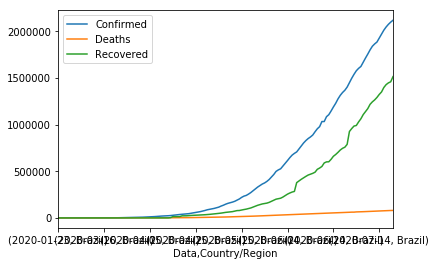

In [3]:
C0=read_kaggle_table(fileName="covid_19_data.csv", CountryName='Brazil',Province=[], timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020')

In [8]:
def read_series(fileName="time_series_covid19_recovered_global.csv", CountryName='Brazil',Province=[], timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020'):
    #fileName - откуда читаем
    # CountryName - какую страну читаем
    # timePeriodStart, timePeriodEnd - от какой до какой даты читаем
    COVID_d = pd.read_csv(fileName)
    #print(COVID_d.tail(20))
    if len(Province)>0:
        COVID_d = COVID_d.loc[(COVID_d['Country/Region']==CountryName)&(COVID_d['Province/State'].isin(Province))]
    else:
        COVID_d = COVID_d.loc[(COVID_d['Country/Region']==CountryName)]
    return COVID_d

In [11]:
def read_table(fileName=['time_series_covid19_deaths_global.csv','time_series_covid19_confirmed_global.csv','time_series_covid19_recovered_global.csv'], CountryName='Brazil',Province=[],prov_Numb=[0], timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020'):
    print(fileName[0])
    C2 = read_series(fileName=fileName[0], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    C1 = read_series(fileName=fileName[1], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    C3 = read_series(fileName=fileName[2], CountryName=CountryName,Province=Province, timePeriodStart=timePeriodStart, timePeriodEnd= timePeriodEnd)
    if len(prov_Numb)>1:
        Covid_data=C1.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))
        Covid_data=np.hstack([Covid_data, C2.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))])
        Covid_data=np.hstack([Covid_data, C3.iloc[prov_Numb,4:].values.sum(axis=1).reshape((-1,1))])
    else:    
        Covid_data=C1.iloc[prov_Numb,4:].values.reshape((-1,1))
        Covid_data=np.hstack([Covid_data, C2.iloc[prov_Numb,4:].values.reshape((-1,1))])
        Covid_data=np.hstack( [Covid_data,C3.iloc[prov_Numb,4:].values.reshape((-1,1))])
    print(Covid_data.shape)
    date = pd.to_datetime(C1.columns[4:])
    COVID_=pd.DataFrame(data=Covid_data,index=date, columns=['Confirmed','Deaths','Recovered'])
    #Нарисуем 
    COVID_.plot()
    plt.show()
    return  COVID_

time_series_covid19_deaths_global.csv
(188, 3)


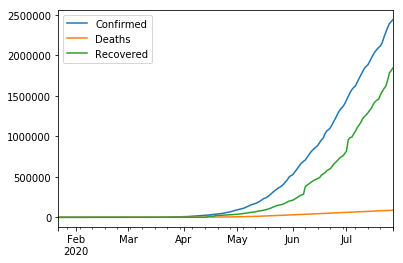

In [12]:
#COVID_ = pd.read_csv('covid_19_data.csv')
COVID_ = read_table(fileName=['time_series_covid19_deaths_global.csv','time_series_covid19_confirmed_global.csv','time_series_covid19_recovered_global.csv'], CountryName='Brazil', timePeriodStart='01.01.2020', timePeriodEnd='28.07.2020')


In [13]:
COVID_.head()

,Confirmed,Deaths,Recovered
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [14]:
COVID_.tail()

,Confirmed,Deaths,Recovered
2020-07-23,2287475,84082,1620313
2020-07-24,2343366,85238,1693214
2020-07-25,2394513,86449,1785359
2020-07-26,2419091,87004,1812913
2020-07-27,2442375,87618,1846641


Сделаем первые разности (производную)

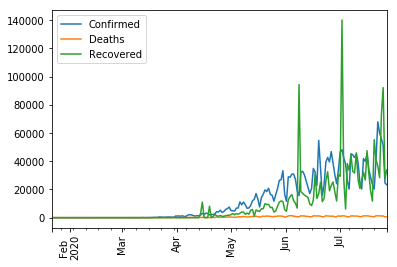

In [15]:
COVID_.loc[:,['Confirmed','Deaths','Recovered']].diff(1).plot()
plt.xticks(label = COVID_.index, rotation=90)

plt.show()



Посмотрим только на выздоровление (так оптимистичней:))

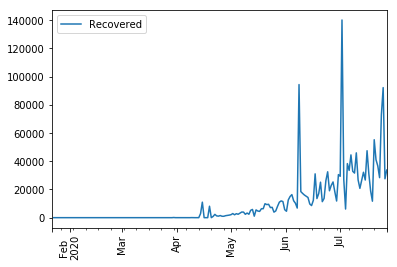

In [16]:
COVID_.loc[:,['Recovered']].diff(1).plot()
plt.xticks(label = COVID_.index, rotation=90)

plt.show()

ОБРЕЖЕМ ДАННЫЕ ПО ПРАВИЛУ: БРАТЬ ПОСЛЕ 100 ПЕРВЫХ СЛУЧАЕВ

In [17]:
ind_start = np.where(COVID_.loc[:,'Confirmed'].values>100)[0]
ind_start[0]

51

In [18]:
COVID_=COVID_.iloc[ind_start[0]:,:]


In [19]:
COVID_.head()

,Confirmed,Deaths,Recovered
2020-03-13,151,0,0
2020-03-14,151,0,0
2020-03-15,162,0,0
2020-03-16,200,0,1
2020-03-17,321,1,2



## Построим признаки

1) Первая разность (производная ряда) - разница с(t)-c(t-1) по всем t 

In [20]:
X1 = COVID_.loc[:, ['Confirmed','Deaths','Recovered']].diff(1).values
X1[0,:] = 0

In [21]:
X1.shape

(137, 3)

2) Сами значения элементов ряда по времени

In [22]:
X2 = COVID_.loc[:, ['Confirmed','Deaths','Recovered']].values 

In [23]:
X2.shape

(137, 3)

3) Добавим признаков по календарю
   

In [24]:
X3 = COVID_.index

In [25]:
X3

DatetimeIndex(['2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22',
               ...
               '2020-07-18', '2020-07-19', '2020-07-20', '2020-07-21',
               '2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25',
               '2020-07-26', '2020-07-27'],
              dtype='datetime64[ns]', length=137, freq=None)

3.1) - день недели по счету

3.2) - день от начала статистики в текущей таблице (для Китая - 1-й день карантина(возможно), для других стран следует посмотреть на первый не 0-й экземпляр по 'Confirmed') - строим как "текущий день года" - "первый день от начала отсчета данных по номеру в году"

In [26]:
X3_1 = pd.to_datetime(X3).dayofweek
X3_2 = pd.to_datetime(X3).dayofyear -  pd.to_datetime(X3[0]).dayofyear

In [27]:
X3_2

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            127, 128, 129, 130, 131, 132, 133, 134, 135, 136],
           dtype='int64', length=137)

Собирем все в кучу

In [28]:
XX = np.concatenate([X1,X2], axis= 1) 

In [29]:
XX = np.concatenate([XX,np.array(X3_1).reshape((X1.shape[0],1))], axis= 1)

In [30]:
XX = np.concatenate([XX,np.array(X3_2).reshape((X1.shape[0],1))], axis= 1)

In [31]:
XX.shape

(137, 8)

Таблица признаков для Китая

In [32]:
COVID_Data = pd.DataFrame(data= XX, index= X3)

In [ ]:
COVID_Data.head()

Сделаем данные для модели:

необходимо определить как далеко будем смотреть назад по ряду от текущего дня - это параметр р - глубина истории

необходимо определить как далеко будем смотреть вперед (предсказывать) - это горизонт прогноза h

In [201]:
p = 3 #  дней назад по истории
h=1    # 1 день вперед предсказываем

Строим выходную часть данных:
 
 предсказываем значения заболеваемости (т.е. признак COVID_Dat.iloc[:,3])
 
 сдвигаем точку предсказания на длину истории р (т.к. не можем предсказывать имея меньше чем р данных для анализа) и ставим первой предсказываемой точкой точку p+h , h - горизонт предсказания

In [202]:
y = COVID_Data.iloc[h+p:,0]
y

2020-03-17      121.0
2020-03-18       51.0
2020-03-19      249.0
2020-03-20      172.0
2020-03-21      228.0
               ...   
2020-07-23    59961.0
2020-07-24    55891.0
2020-07-25    51147.0
2020-07-26    24578.0
2020-07-27    23284.0
Name: 0, Length: 133, dtype: float64

Строим данные для входной части модели:

наши р дней истории по всем признакам  начиная от 0-го дня используем блоками  XX[i:i+p,:] для i = 0,64

последний предсказываемый день будет 75-й (5.04.2020), т.е. данные для предсказания кончаются в 74-й день (4.04.2020) (сегодня 9.04 - последний день 8.04 - 78-й день)

векторизируем весь блок данных истории в вектор длины 8*р и дописываем в примеры для обучения  X

In [203]:
X =[]
for i in range(len(y)):
    xx = XX[i:i+p,:]
    X.append(xx.reshape(8*p))

Приводим все к одному виду для обработки в модели

In [204]:
X = np.array(X).reshape((COVID_Data.shape[0]-p-h,8*p))
y=np.array(y).reshape((COVID_Data.shape[0]-p-h,1))

In [205]:
X.shape

(133, 24)

In [206]:
y.shape

(133, 1)

Можно строить модель

In [218]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler

N=10
x_train,y_train,x_test,y_test=X[:-N,:],y[:-N,:],X[-N:,:],y[-N:,:]
# пока строим одну
model_lb = LinearRegression()
# и еще одну
model_gb = GradientBoostingRegressor(n_estimators=100)

In [219]:
model_lb.fit(x_train,y_train)
model_gb.fit(x_train,y_train)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [220]:
y_pred = model_lb.predict(x_test)
y_pred_t = model_lb.predict(x_train)

y_predg = model_gb.predict(x_test)
y_predg_t = model_gb.predict(x_train)

In [221]:
error_ =np.mean(np.abs(y_pred-y_test))
print(error_)

error_ =np.mean(np.abs(y_predg-y_test))
print(error_)

13297.68454238064
15962.289665403569


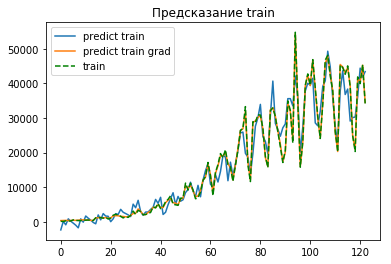

In [222]:
plt.plot(y_pred_t, label='predict train')
plt.plot(y_predg_t, label='predict train grad')
plt.plot(y_train,'--g', label='train')
plt.legend()
plt.title('Предсказание train')
plt.show()

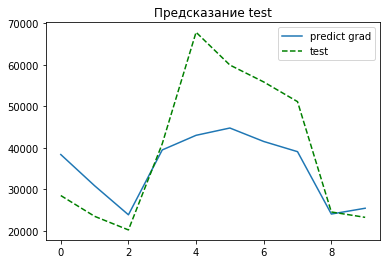

In [223]:
#plt.plot(y_pred, label='predict')
plt.plot(y_predg, label='predict grad')
plt.plot(y_test, '--g',label='test')
plt.legend()
plt.title('Предсказание test')
plt.show()

Вообще получилось хорошо :) - довольно точно

In [224]:
error_p =np.mean(np.abs(y_test.reshape((N))-y_predg.reshape((N))))

print('error in MAE :', error_p)

error in MAE : 9143.324188330245


In [225]:
err = np.abs(y_test.reshape((N))-y_predg.reshape((N)))
err_std = np.std(err)

print('anomal: ', np.where(err>err_std*3)[0])

anomal:  [4]


In [227]:
y_test.reshape((N))-y_predg.reshape((N))

array([-9875.79756238, -7365.61196572, -3643.83091155,  1491.64374756,
       24820.12231992, 15165.86713091, 14334.273054  , 12047.26884249,
         496.74464896, -2192.0816998 ])

## Box-Cox преобразование

In [228]:
import scipy.stats as scs

In [229]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

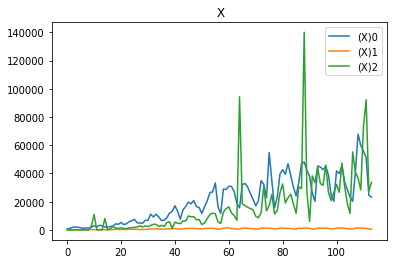

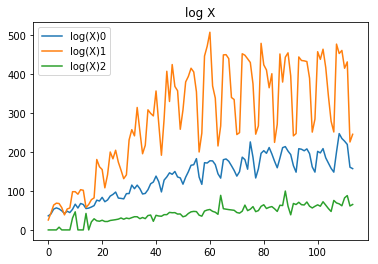

In [232]:

X_log0, lmbda0 = scs.boxcox(XX[23:,0]+1)
X_log1, lmbda1 = scs.boxcox(XX[23:,1]+1)
X_log2, lmbda2 = scs.boxcox(np.abs(XX[23:,2])+1) # добавляю аbs для обхода ошибки в аномалии

plt.plot(XX[23:,0], label='(X)0')
plt.plot(XX[23:,1], label='(X)1')
plt.plot(XX[23:,2], label='(X)2')
plt.legend()
plt.title(' X')
plt.show()

plt.plot(X_log0[:], label='log(X)0')
plt.plot(X_log1[:], label='log(X)1')
plt.plot(X_log2[:], label='log(X)2')
plt.legend()
plt.title('log X')
plt.show()

Текущее число больных

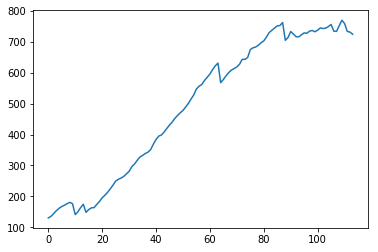

In [233]:
X_dif=XX[23:,3]-XX[23:,4]-XX[23:,5]
X_dif_log, lmbda_dif = scs.boxcox(X_dif+1)
plt.plot(X_dif_log)
plt.show()

Соберем из Логарифмированных признаков новую модель

In [234]:
X_log = np.concatenate([X_log0.reshape((X_log0.shape[0],1)),(X_log1).reshape((X_log1.shape[0],1))], axis= 1)
X_log = np.concatenate([X_log,(X_log2).reshape((X_log2.shape[0],1))], axis= 1)
X_log = np.concatenate([X_log,(X_dif_log).reshape((X_dif_log.shape[0],1))], axis= 1)

y = X_log[h+p:,0].reshape((X_log0.shape[0]-h-p,1))

X_log_all =[]
for i in range(len(y)):
    xx = X_log[i:i+p,:]
    X_log_all.append(xx.reshape(X_log.shape[1]*p))

    N=-40
X_log_all=np.array(X_log_all)
x_trainl,y_train,x_testl,y_test=X_log_all[:N,:],y[:N,:],X_log_all[N:,:],y[N:,:]

x_trainl.shape

(70, 12)

In [235]:
y_train.shape

(70, 1)

In [236]:
model_lb.fit(x_trainl,y_train)
model_gb.fit(x_trainl,y_train)

C:\Users\1\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [237]:
y_pred = model_lb.predict(x_testl)
y_pred_t = model_lb.predict(x_trainl)

y_predg = model_gb.predict(x_testl)
y_predg_t = model_gb.predict(x_trainl)

In [238]:
error_ =np.mean(np.abs(y_pred-y_test))
print(error_)

error_ =np.mean(np.abs(y_predg-y_test))
print(error_)

20.433598582859
32.25770998810787


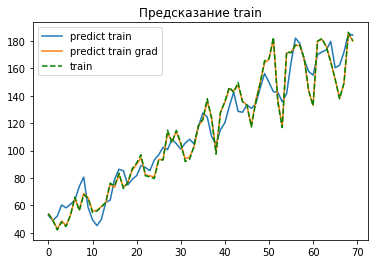

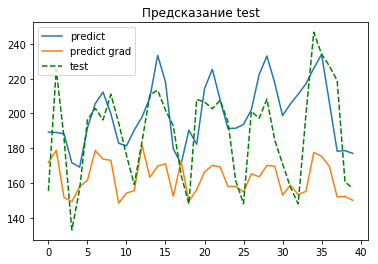

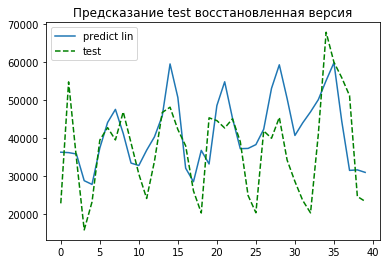

In [249]:
plt.plot(y_pred_t, label='predict train')
plt.plot(y_predg_t, label='predict train grad')
plt.plot(y_train,'--g', label='train')
plt.legend()
plt.title('Предсказание train')
plt.show()
plt.plot(y_pred, label='predict')
plt.plot(y_predg, label='predict grad')
plt.plot(y_test, '--g',label='test')
plt.legend()
plt.title('Предсказание test')
plt.show()

#plt.plot(invboxcox(y_pred,lmbda0), label='predict')
plt.plot(invboxcox(y_pred,lmbda0), label='predict lin')
plt.plot(invboxcox(y_test,lmbda0), '--g',label='test')
plt.legend()
plt.title('Предсказание test восстановленная версия')
plt.show()

In [251]:
error_p =np.mean(np.abs(invboxcox(y_pred,lmbda0)-invboxcox(y_test,lmbda0))/invboxcox(y_test,lmbda0))*100
print('MAPE :' , error_p)

MAPE : 30.67354048577388


In [252]:
error_p =np.mean(np.abs(invboxcox(y_test[1:],lmbda0)-invboxcox(y_test[:-1],lmbda0))/invboxcox(y_test[:-1],lmbda0))*100
print('MAPE :' , error_p)

MAPE : 32.16095664571683


In [253]:
error_p =np.mean(np.abs(invboxcox(y_test,lmbda0)-np.mean(invboxcox(y_test,lmbda0)))/invboxcox(y_test,lmbda0))*100
print('MAPE :' , error_p)

MAPE : 32.54533975446133
